### **PEST DETECTION - MobileNetV2 MODEL**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random
import warnings
warnings.filterwarnings("ignore")

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras import Model
# from tensorflow.keras.layers.experimental import preprocessing

# System Libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='whitegrid')

In [1]:
import cv2

print("TensorFlow version:", cv2.__version__)


TensorFlow version: 4.9.0


#### Data Preprocessing

Unzip the pest image dataset (zipped folder)

In [15]:
!pip install zipfile36

In [16]:
!unzip /content/pestopia.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
dataset = "pestopia/Datasets/Pest_Dataset"

Visualize the Pest Images

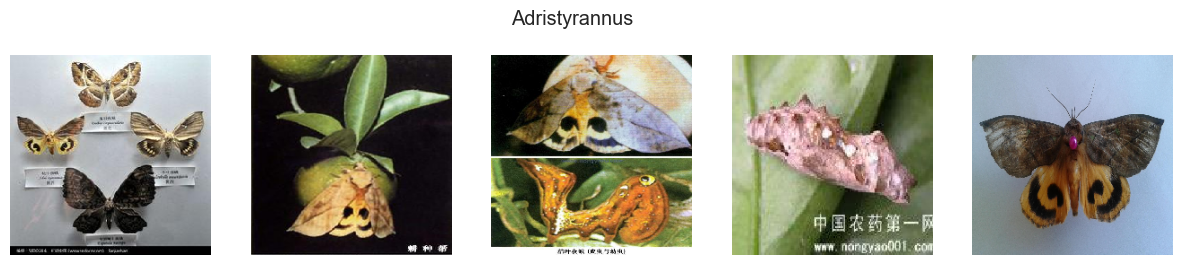

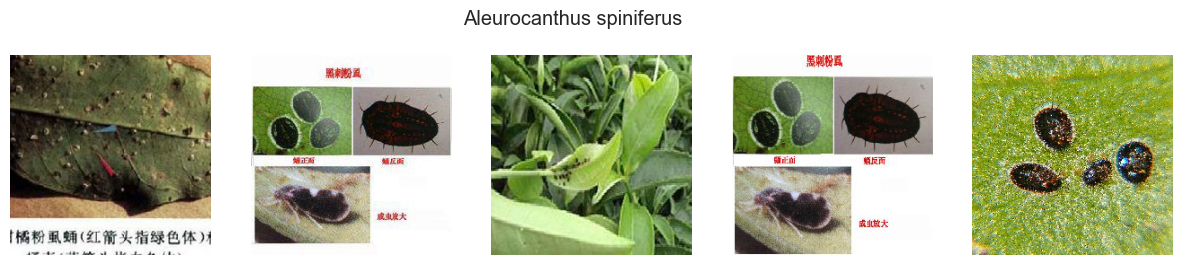

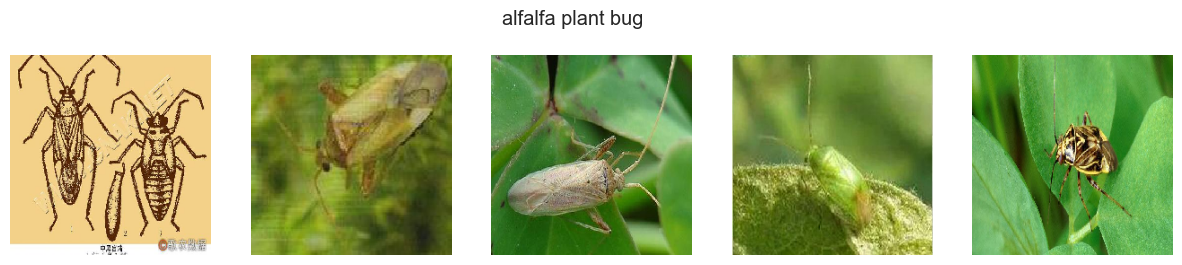

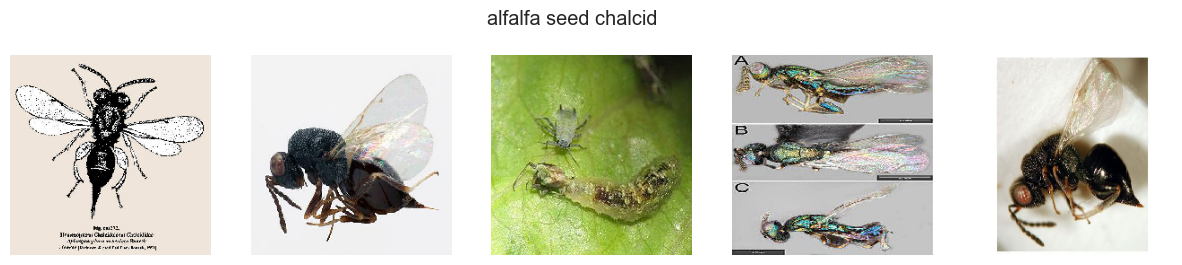

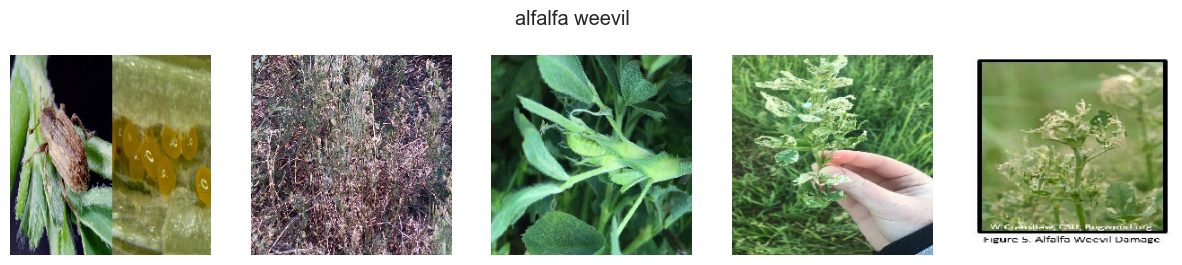

In [4]:
from tensorflow.keras.preprocessing.image import load_img
# Step 2: Print 5 Images from Each Pest Subfolder
image_count=0

# Loop through each pest subfolder
for folder_name in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder_name)

    # Check if the current item is a directory (pest subfolder)
    if os.path.isdir(folder_path):
        # Get a list of all images in the current pest subfolder
        images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Randomly select 5 images from the list
        selected_images = random.sample(images, 5)

        # Print the selected images in multiple columns
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        fig.suptitle(folder_name)

        image_count+=1
        for i, image_name in enumerate(selected_images):

            image_path = os.path.join(folder_path, image_name)
            image = load_img(image_path, target_size=(224, 224))

            axes[i].imshow(image)
            axes[i].axis('off')

        if image_count>=5:
            break

        plt.show()

Create a dataframe of the pests with the image path and the labels




In [5]:
# Step 2: Create DataFrame and Store Data

# Initialize lists to store image paths and corresponding labels
image_paths = []
labels = []

# Loop through each pest subfolder
for folder_name in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder_name)

    # Check if the current item is a directory (pest subfolder)
    if os.path.isdir(folder_path):
        # Get a list of all images in the current pest subfolder
        images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for image_name in images:
            image_path = os.path.join(folder_path, image_name)
            image_paths.append(image_path)
            labels.append(folder_name)

# Create a DataFrame from the collected data
data = {
    'image_path': image_paths,
    'label': labels
}
df = pd.DataFrame(data)

# Display the DataFrame
df.head()

,image_path,label
0,pestopia/Datasets/Pest_Dataset\Adristyrannus\6...,Adristyrannus
1,pestopia/Datasets/Pest_Dataset\Adristyrannus\6...,Adristyrannus
2,pestopia/Datasets/Pest_Dataset\Adristyrannus\6...,Adristyrannus
3,pestopia/Datasets/Pest_Dataset\Adristyrannus\6...,Adristyrannus
4,pestopia/Datasets/Pest_Dataset\Adristyrannus\6...,Adristyrannus


Plotting of the distribution characteristics of the pests

In [6]:


subset_df = df.sample(n=50, random_state=42)

# Calculate the counts of each pest type
pest_counts = subset_df['label'].value_counts()

# Create a DataFrame from the counts
pest_counts_df = pd.DataFrame({'Pest Type': pest_counts.index, 'Count': pest_counts.values})



Train Test Splitting and Data Generator

In [7]:
# Split ratio between training and validation data
split_ratio = 0.8

# Create ImageDataGenerator with data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=1 - split_ratio  # Set validation split
)


test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2
    )

In [8]:
# Load and preprocess training data using the generator
train_generator = train_datagen.flow_from_directory(
    dataset,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Specify training subset
)

# Load and preprocess validation data using the generator
validation_generator = train_datagen.flow_from_directory(
    dataset,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Specify validation subset
)

Found 44810 images belonging to 132 classes.
Found 11104 images belonging to 132 classes.


In [9]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [10]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: []


In [11]:
# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
predictions = Dense(132, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)

Epoch 1/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 797s 566ms/step - accuracy: 0.2158 - loss: 3.7013 - val_accuracy: 0.3769 - val_loss: 2.6158
Epoch 2/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - accuracy: 0.3438 - loss: 1.4290 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 684s 488ms/step - accuracy: 0.3428 - loss: 2.7590 - val_accuracy: 0.4135 - val_loss: 2.4388
Epoch 4/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.4688 - loss: 1.1618 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 621s 443ms/step - accuracy: 0.3725 - loss: 2.5863 - val_accuracy: 0.4169 - val_loss: 2.3790
Epoch 6/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.3750 - loss: 1.3705 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 698s 498ms/step - accuracy: 0.3928 - loss: 2.4687 - val_accuracy: 0.4349 - val_loss: 2.3008
Epoch 8/30
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 0s 25

Saving the Model

In [12]:
# Save the trained model
model.save('model/agrovoicev2.h5') #change dir to a path where the saved model is to be uploaded in your drive

In [17]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [18]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [20]:
import joblib

# Assuming your model is named 'model'
joblib.dump(model, 'model1.pkl')

PicklingError: Can't pickle <function Layer._initializer_tracker.<locals>.<lambda> at 0x000001C6A1CB8280>: it's not found as keras.src.layers.layer.Layer._initializer_tracker.<locals>.<lambda>

In [31]:
import shutil

# Specify the source and destination paths
source_path = 'model1.pkl'
destination_path = '/content/drive/MyDrive/LenovoIdeapadSlim3ifolders/FinalYearProject/model1.pkl' #change dir to a path where the saved model is to be uploaded in your drive

# Copy the file to Google Drive
shutil.copy(source_path, destination_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/LenovoIdeapadSlim3ifolders/FinalYearProject/model1.pkl'

In [21]:
# Create label mapping based on subdirectory names
label_mapping = {i: label for i, label in enumerate(sorted(os.listdir(dataset)))}

In [22]:
label_mapping

{0: 'Adristyrannus',
 1: 'Aleurocanthus spiniferus',
 2: 'Ampelophaga',
 3: 'Aphis citricola Vander Goot',
 4: 'Apolygus lucorum',
 5: 'Bactrocera tsuneonis',
 6: 'Beet spot flies',
 7: 'Black hairy',
 8: 'Brevipoalpus lewisi McGregor',
 9: 'Ceroplastes rubens',
 10: 'Chlumetia transversa',
 11: 'Chrysomphalus aonidum',
 12: 'Cicadella viridis',
 13: 'Cicadellidae',
 14: 'Colomerus vitis',
 15: 'Dacus dorsalis(Hendel)',
 16: 'Dasineura sp',
 17: 'Deporaus marginatus Pascoe',
 18: 'Erythroneura apicalis',
 19: 'Field Cricket',
 20: 'Fruit piercing moth',
 21: 'Gall fly',
 22: 'Icerya purchasi Maskell',
 23: 'Indigo caterpillar',
 24: 'Jute Stem Weevil',
 25: 'Jute aphid',
 26: 'Jute hairy',
 27: 'Jute red mite',
 28: 'Jute semilooper',
 29: 'Jute stem girdler',
 30: 'Jute stick insect',
 31: 'Lawana imitata Melichar',
 32: 'Leaf beetle',
 33: 'Limacodidae',
 34: 'Locust',
 35: 'Locustoidea',
 36: 'Lycorma delicatula',
 37: 'Mango flat beak leafhopper',
 38: 'Mealybug',
 39: 'Miridae',
 

Model Testing and Evaluation

In [25]:
# Test Image
image_path = 'bee.png' #change dir to a path where the test image is uploaded in your drive

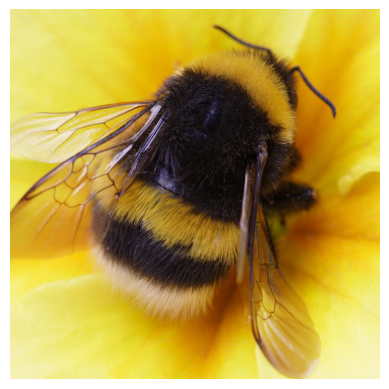

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image
img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load the trained model
model = tf.keras.models.load_model('model/agrovoicev2.h5') #change dir to a path where the saved model has been uploaded in your drive

# Load and preprocess the image
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    preprocessed_image = preprocess_input(image_array)
    return preprocessed_image

# Perform prediction
def predict_plant(image_path, label_mapping):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)

    # Map model's numeric predictions to labels
    predicted_label_index = np.argmax(predictions)
    predicted_label = label_mapping[predicted_label_index]
    confidence = predictions[0][predicted_label_index]

    return predicted_label, confidence

# Provide the path to the image you want to classify
predicted_label, confidence = predict_plant(image_path, label_mapping)

# Print the prediction
print(f"Predicted Label: {predicted_label}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Predicted Label: blister beetle
Confidence: 0.44


Results and Evaluation

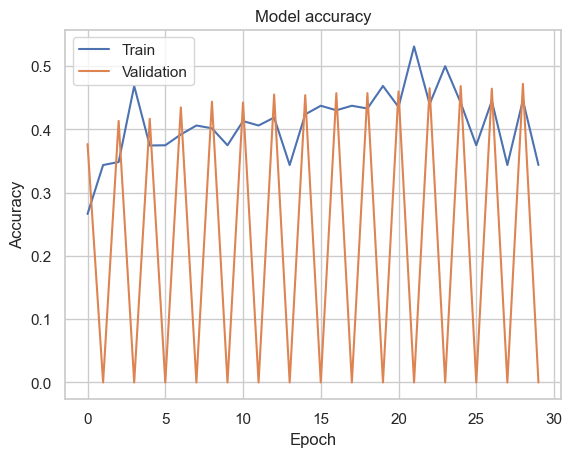

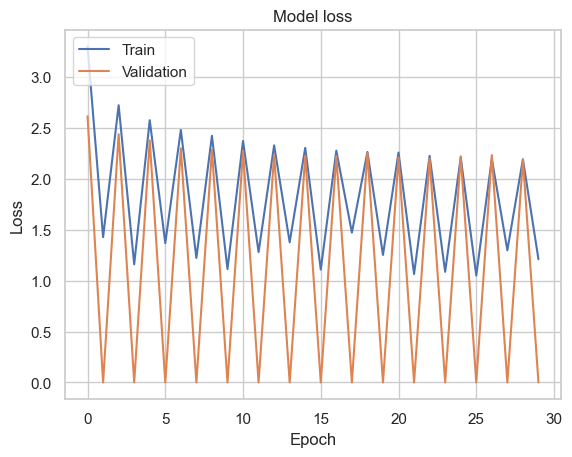

In [28]:
### Training and Validation Curves
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [29]:
results = model.evaluate(validation_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 2.93847
Test Accuracy: 32.98%


Classification Report

In [30]:
import numpy as np
from sklearn.metrics import classification_report

# Generate predictions
predictions = model.predict(validation_generator)

# Convert predictions from one-hot encoded format to class labels
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

# Get class names
class_names = list(validation_generator.class_indices.keys())
print(class_names)
# Generate classification report
report = classification_report(validation_generator.classes, predicted_labels, target_names=class_names)

# Print the classification report
print(report)


347/347 ━━━━━━━━━━━━━━━━━━━━ 119s 340ms/step
[20 39 86 ...  7 80 30]
['Adristyrannus', 'Aleurocanthus spiniferus', 'Ampelophaga', 'Aphis citricola Vander Goot', 'Apolygus lucorum', 'Bactrocera tsuneonis', 'Beet spot flies', 'Black hairy', 'Brevipoalpus lewisi McGregor', 'Ceroplastes rubens', 'Chlumetia transversa', 'Chrysomphalus aonidum', 'Cicadella viridis', 'Cicadellidae', 'Colomerus vitis', 'Dacus dorsalis(Hendel)', 'Dasineura sp', 'Deporaus marginatus Pascoe', 'Erythroneura apicalis', 'Field Cricket', 'Fruit piercing moth', 'Gall fly', 'Icerya purchasi Maskell', 'Indigo caterpillar', 'Jute Stem Weevil', 'Jute aphid', 'Jute hairy', 'Jute red mite', 'Jute semilooper', 'Jute stem girdler', 'Jute stick insect', 'Lawana imitata Melichar', 'Leaf beetle', 'Limacodidae', 'Locust', 'Locustoidea', 'Lycorma delicatula', 'Mango flat beak leafhopper', 'Mealybug', 'Miridae', 'Nipaecoccus vastalor', 'Panonchus citri McGregor', 'Papilio xuthus', 'Parlatoria zizyphus Lucus', 'Phyllocnistis citrell

In [34]:
# Save the trained model
model.save('model/agrovoicev3.h5') #change dir to a path where the saved model is to be uploaded in your drive